# Real data

Let's look at an example of real data.

In this notebook we'll be looking at a lower spine MRI scan. The scan has 4 series made in different resolutions. We'll make an experiment - try to load all four seriens and resample the intersecting part into one unified volume.

The experiment approach will be the following:

1. Load and view the raw data
2. Find overlaping region and define an ROI (region of interest) out of it.
3. Crop and upsample all volumes using the ROI.
4. Blend volumes
5. Downsample resulting volume.


In [1]:
import os
try:
    import numpy as np
    import JupyterNotebooksLib as slicernb
except ImportError as e:
    print(f'Imports failed with the following message: {e}.\nSlicer environment was not setup correctly.')

In [2]:
sys.path.append(os.getcwd())
import playground_utils

And some more helper functions that will move to the `playground_utils.py`

In [3]:
def fit_slice_view(sliceView: str = 'all'):
    """
    Fit slice field of view to data.

    :param      sliceView:   Either one of default slice views ['Red', 'Green', 'Yellow'] or 'all'.
    :type       sliceView:   str
    """
    if sliceView == 'all':
        sliceView = slicer.app.layoutManager().sliceViewNames()
    elif sliceView in ['Red', 'Yellow' ,'Green']:
        sliceView = [sliceView]    
    for sv in sliceView:
        sliceViewWidget = slicer.app.layoutManager().sliceWidget(sv)
        sliceWidgetLogic = sliceViewWidget.sliceLogic()
        sliceWidgetLogic.FitSliceToAll()
    pass

In [4]:
def log_image_info(volume: slicer.vtkMRMLScalarVolumeNode):
    """Log basic image information to console."""
    print(f'Volume name: {volume.GetName()}')
    print(f'Origin: {volume.GetOrigin()}')
    print(f'Spacing: {volume.GetSpacing()}')
    print(f'Dimensions: {volume.GetImageData().GetDimensions()}\n')

In [5]:
def layout_3_volumes(volumeList: list):
    """Prepare 3x3 layout with 3 volumes in slice views."""
    ORIENTATIONS = ["Axial", "Sagittal", "Coronal"]
    THREE_BY_THREE_SLICES = [['Red', 'Yellow', 'Green'],
                             ['Slice4', 'Slice5', 'Slice6'],
                             ['Slice7', 'Slice8', 'Slice9']]
    for volumeIndex in range(3):
        inputVolumeNode = slicer.mrmlScene.GetFirstNodeByName(volumeList[volumeIndex])
        for view in THREE_BY_THREE_SLICES[volumeIndex]:
            playground_utils.show_slice_in_slice_view(volumeNode=inputVolumeNode,
                                                      sliceView=view)
            sliceWidgetNode = slicer.app.layoutManager().sliceWidget(view).mrmlSliceNode()
            sliceWidgetNode.SetOrientation(ORIENTATIONS[THREE_BY_THREE_SLICES[volumeIndex].index(view)])

---

## Data import

Let's load the NRRD files that are in the `img/` folder.

In [6]:
MRI_VOLUMES = ['Spine_MRI_Sag2', 'Spine_MRI_Sag1', 'Spine_MRI_Cor']

In [7]:
for volumeName in MRI_VOLUMES:
    file_path = os.path.join(os.getcwd(), 'img', f'{volumeName}.nrrd')
    volumeNode = slicer.util.loadVolume(file_path)
    volumeNode.SetName(volumeName)
    log_image_info(volumeNode)

Volume name: Spine_MRI_Sag2
Origin: (-26.191863116587005, 119.51052543690004, 184.9111451422098)
Spacing: (1.3671875000000004, 1.3671875, 4.999999931508104)
Dimensions: (256, 256, 13)

Volume name: Spine_MRI_Sag1
Origin: (-26.191863116587005, 119.51052543690004, 184.9111451422098)
Spacing: (0.6835937500000002, 0.68359375, 4.999999931508104)
Dimensions: (512, 512, 13)

Volume name: Spine_MRI_Cor
Origin: (158.68056418085007, -59.689050348214984, 187.48942557722987)
Spacing: (0.9375000000000007, 0.9375000000000004, 5.0000002922187194)
Dimensions: (320, 320, 13)



So there are 3 volumes all of which have different resolutions. Let's setup a 3x3 slice view layout and render them.

In [8]:
lm = slicer.app.layoutManager()
lm.setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutThreeByThreeSliceView)

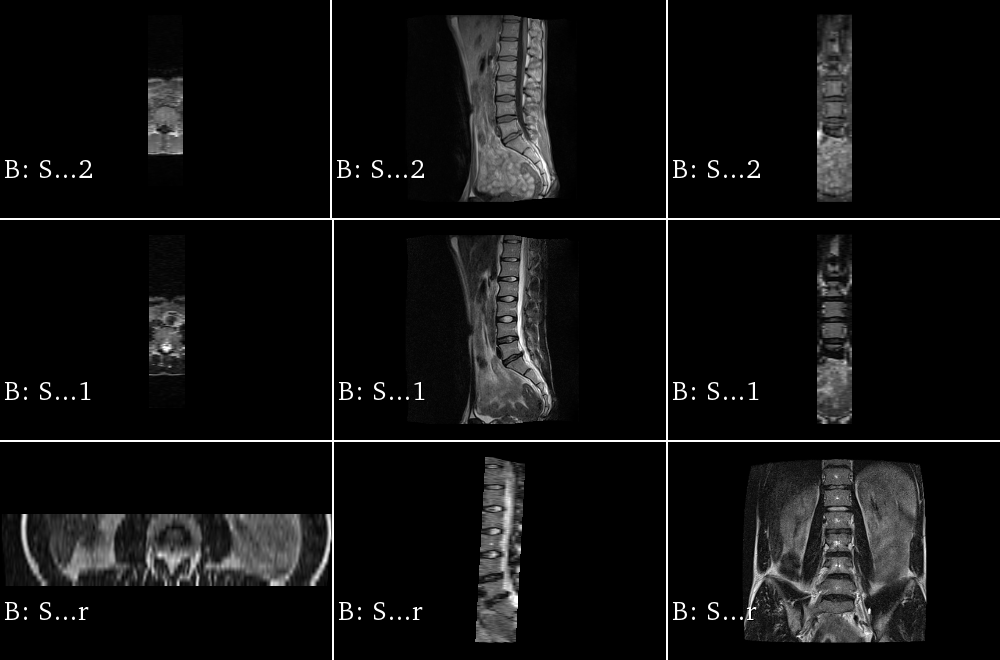

In [9]:
layout_3_volumes(MRI_VOLUMES)
fit_slice_view()
slicernb.ViewDisplay('ThreeByThreeSlice', False)

Now let's select a ROI where all imported volumes overlap. It's in the area of the Lumbosacral Joint (L5-S1).

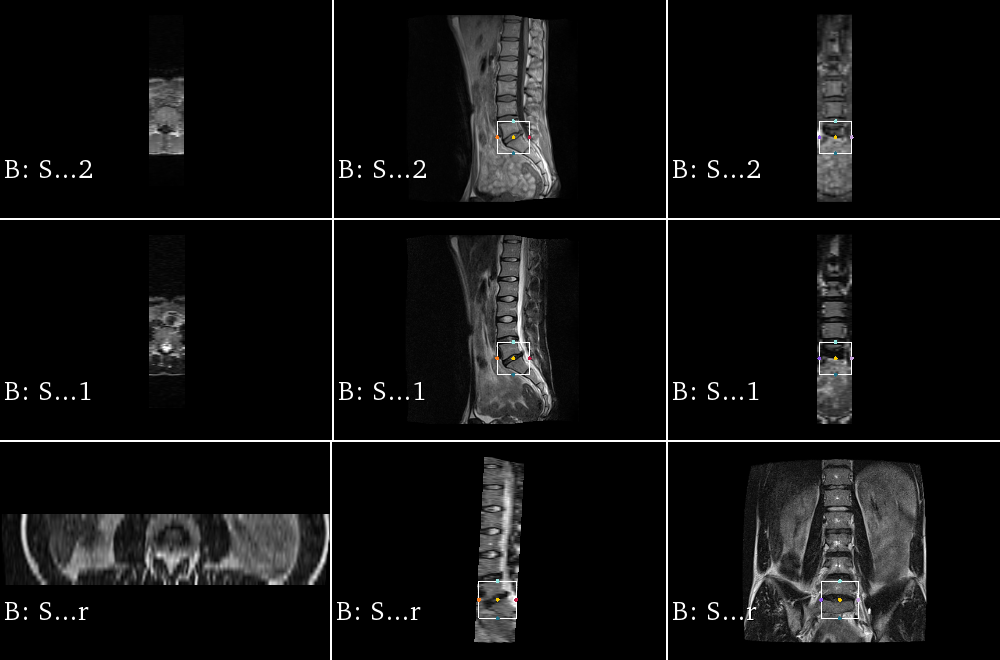

In [10]:
roi = slicer.vtkMRMLAnnotationROINode()
roi.Initialize(slicer.mrmlScene)
roi.SetXYZ(0,-80,-42)
roi.SetRadiusXYZ(30,30,30)

fit_slice_view()
slicernb.ViewDisplay('ThreeByThreeSlice', False)

And let's crop all the volumes that we have using this ROI.

The Spacing scale will be set to 0.5 for the volumes to come out upscaled and we'll set Isotropic resampling to `True` to have isotropic voxels in the resulting array.

In [11]:
cropVolumeNode = slicer.vtkMRMLCropVolumeParametersNode()
cropVolumeNode.SetScene(slicer.mrmlScene)
cropVolumeNode.SetName('Sample_CropVolume_node')
cropVolumeNode.SetIsotropicResampling(True)
cropVolumeNode.SetSpacingScalingConst(0.3)
slicer.mrmlScene.AddNode(cropVolumeNode)

for volumeName in MRI_VOLUMES:
    vol = slicer.mrmlScene.GetFirstNodeByName(volumeName)
    cropVolumeNode.SetInputVolumeNodeID(vol.GetID())
    cropVolumeNode.SetOutputVolumeNodeID(vol.GetID())
    cropVolumeNode.SetROINodeID(roi.GetID())
    cropVolumeLogic = slicer.modules.cropvolume.logic()
    cropVolumeLogic.Apply(cropVolumeNode)
    log_image_info(vol)

Volume name: Spine_MRI_Sag2
Origin: (-29.7362995147705, -109.73600006103513, -71.73629760742186)
Spacing: (0.41015624999999994, 0.41015624999999994, 0.41015624999999994)
Dimensions: (146, 146, 146)

Volume name: Spine_MRI_Sag1
Origin: (-29.838899612426758, -109.83899688720703, -71.83889770507812)
Spacing: (0.20507812499999997, 0.20507812499999997, 0.20507812499999997)
Dimensions: (292, 292, 292)

Volume name: Spine_MRI_Cor
Origin: (-29.812500000000004, -109.81300354003906, -71.8125)
Spacing: (0.28125, 0.28125, 0.28125)
Dimensions: (213, 213, 213)



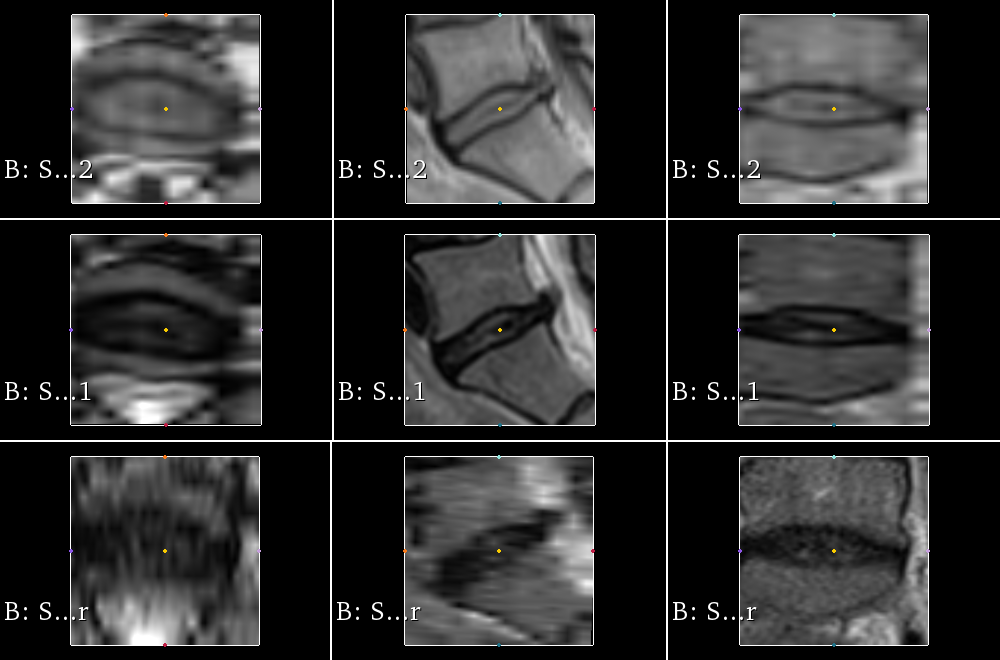

In [12]:
fit_slice_view()
slicernb.ViewDisplay('ThreeByThreeSlice', False)

After cropping the initoal volumes and converting non-isotropic voxels (rectangular) to isotropic (square),
we're still left with volumes that have different shapes.
In order to blend them together we need to resample them to unified pixel spacing.
As the result of resampling the voxels will have same shape and the images will have same dimensions.

In [13]:
parameters = {}
parameters["outputPixelSpacing"] = (0.3, 0.3, 0.3)

for volumeName in MRI_VOLUMES:
    volumeNode = slicer.mrmlScene.GetFirstNodeByName(volumeName)
    parameters["InputVolume"] = volumeNode
    parameters["OutputVolume"] = volumeNode
    cliNode = slicer.cli.runSync(slicer.modules.resamplescalarvolume, None, parameters)

This is how the resampled images look like.

*`slicer.cli.runSync` refreshes all slice views, so we need to lay the slices out again*

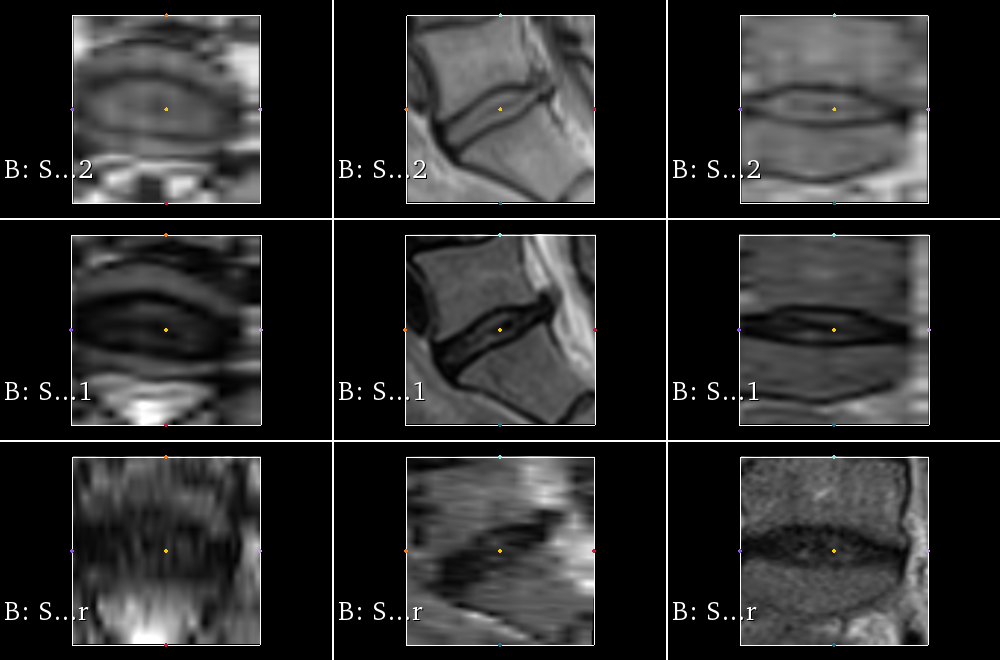

In [14]:
layout_3_volumes(MRI_VOLUMES)
fit_slice_view()
slicernb.ViewDisplay('ThreeByThreeSlice', False)

After cropping and upsampling let's merge the 3 volumes with each other by performing a simple arithmetic operation with them.

In [15]:
resultArray = None

for volumeName in MRI_VOLUMES:
    volumeArray = slicer.util.arrayFromVolume(slicer.mrmlScene.GetFirstNodeByName(volumeName))
    if resultArray is None:
        resultArray = volumeArray
    else:
        resultArray = resultArray + volumeArray

resultArray = resultArray ^ 3

outputVolumeNode = slicer.modules.volumes.logic().CloneVolume(
                            slicer.mrmlScene.GetFirstNodeByName(MRI_VOLUMES[0]),
                            'L5_S1 disc')
slicer.util.updateVolumeFromArray(outputVolumeNode, resultArray)

And downsample them to the pixel spacing like the source volumes had.

In [16]:
parameters = {}
parameters["outputPixelSpacing"] = (0.68, 0.68, 0.68)

parameters["InputVolume"] = outputVolumeNode
parameters["OutputVolume"] = outputVolumeNode
cliNode = slicer.cli.runSync(slicer.modules.resamplescalarvolume, None, parameters)

To render the result from python we'll change the layout and add a small hack to reset intensity mapping for our volume (switch intensity interpolation off and back on)

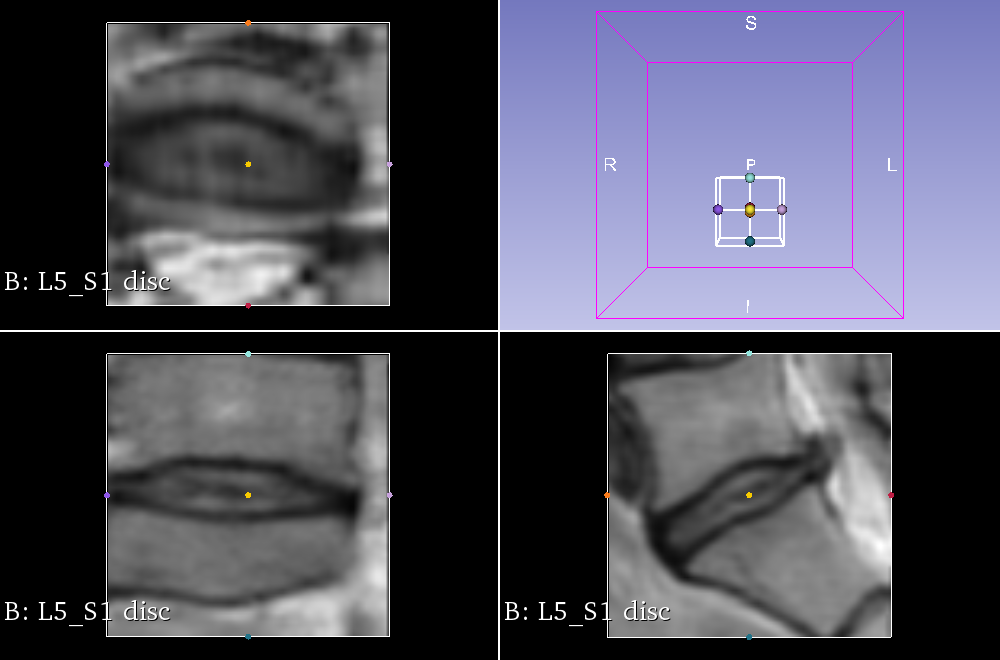

In [17]:
lm.setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutFourUpView)
setSliceViewerLayers(background=outputVolumeNode)
fit_slice_view()

for node in slicer.util.getNodes('*').values():
    if node.IsA('vtkMRMLScalarVolumeDisplayNode'):
        node.SetInterpolate(0)
        node.SetInterpolate(1)

slicernb.ViewDisplay('FourUp', False)

And let's save the resulting volume to use it in the Segmentation notebook

In [18]:
slicer.util.saveNode(outputVolumeNode, os.path.join(os.getcwd(), 'img', 'l5_s1_disc.nrrd'))

True